In [ ]:
#default_exp core.train

In [ ]:
#export
import torch
from torch import nn
from torch.nn import functional as F
from vase.config import DATA_PATH, PARAM_PATH


In [ ]:
#hide
from vase.core.models import PaperVanillaVAE, FCVAE
from vase.core.datasets.moving_mnist import MovingFashionMNIST, CommonMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os

In [ ]:
train = False
latents=24
batch_size=64

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
fc_vae_helper = FCVAE(latents)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, _ = iter(mnist_loader).next()
rec, mu, logvar = fc_vae_helper(mnist_batch)
fashion_data = MovingFashionMNIST(DATA_PATH, transform=ToTensor(), download=True)
fashion_loader = DataLoader(fashion_data, 64, shuffle=True)
fashion_batch, _, _ = iter(fashion_loader).next()


# Training For VASE
> all losses and training code for VASE (variational inference, environmental inference, latent masking, generative replay, object classification, location regresion)

## Problem Setup

TODO: add all the distributions

## Standard VAE (Reconstruction + Target KL)
The paper's "The Minimum Length Description (MDL)" loss is a variannt of the standard VAE ELBO loss, maximimzing the likelihood while minimizing the KL Divergence to the prior:

$$\mathcal{L}_{MDL}(\phi, \theta) = E_{\mathbf{z}^s \sim q_{\phi}(\dot|\mathbf{x}^s)}[-\log{p_{\theta}(\mathbf{x}|\mathbf{z}^s, s)}] + \gamma |KL(q_{\phi}(\mathbf{z}^s|\mathbf{x}^s)||p(z)) - C|$$


However, you'll notice the KL divergence term is slighly non-standard. Rather than penalizing the KLDiv at a fixed rate, the loss is the difference between the KLDiv and a dynamic target $C$, which increases over the course of training, allowing for gradually more representation capacity. This trick was taken from [Understanding disentanglement in the $\beta$-VAE](https://arxiv.org/pdf/1804.03599.pdf) (Note that in keeping with that paper, I have dropped the square from the KL term)

For now we'll also drop the environment super script s, just training an autoencoder on iid data:

$$\mathcal{L}_{MDL}(\phi, \theta) = E_{\mathbf{z} \sim q_{\phi}(\dot|\mathbf{x})}[-\log{p_{\theta}(\mathbf{x}|\mathbf{z})}] + \gamma |KL(q_{\phi}(\mathbf{z}|\mathbf{x})||p(z)) - C|$$

### Reconstruction Loss

We'll use Binary Cross Entropy Loss with $y$ the ground truth image $x$, and $p(y)$ the reconstructed image. In terms of log likelihood, I'm not really sure how this makes sense, but it seems to be how its done... (TODO figure this out)

In [ ]:
F.binary_cross_entropy(rec, mnist_batch, reduction='none').shape

torch.Size([64, 1, 28, 28])

In [ ]:
F.binary_cross_entropy(rec, mnist_batch, reduction='none').flatten(start_dim=1).sum(dim=1).shape

torch.Size([64])

In [ ]:
#export
def rec_likelihood(x, x_rec):
    """Returns element wise reconstruction loss across batch"""
    return F.binary_cross_entropy(x_rec, x, reduction='none').flatten(start_dim=1).sum(dim=1)

In [ ]:
#export 
def reconstruction_loss(x, x_rec):
    """Returns mean reconstruction loss across batch"""
    return torch.mean(rec_likelihood(x, x_rec))

### KL Div Target

Recall the definition of KL Divergence is the expected value under the reference distribution of the information ratio (or something like that):

$$D_{KL}(q||p) = E_q[\log{\frac{q}{p}}] $$

So in our case, with
$$KL(q_{\phi}(\mathbf{z}|\mathbf{x})||p(z))$$
we have 

$$KL(q_{\phi}(\mathbf{z}|\mathbf{x})||p(z)) = E_{q_{\phi}(\mathbf{z}|x)}[\log{q_{\phi}(\mathbf{z}|\mathbf{x})} - \log{p(z)}]$$

Note that both $q_{\phi}(\mathbf{z}|x))$ and $p(z)$ are diagonal gaussians. The KL divergence between diagonal gaussians can be [derived analytically](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians), and is given by:

$$ \log{\frac{\sigma_2}{\sigma_1}} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} - \frac{1}{2}$$

Since $p(z)$ is standard normal, we have $\mu_2 = 0, \sigma_2 = 1$, reducing the equation to:

$$ \frac{1}{2}(\sigma_1^2 + \mu_1^2 - 1) - \log{\sigma_1^2}$$

TODO: see Kigma 2014 for real derivation - this one is off (or Kigma's is off, idk...)

#### KLDiv Standard Normal

In [ ]:
kl_div = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar, dim=1)

In [ ]:
assert kl_div.shape == torch.Size([batch_size])

In [ ]:
#export
def kl_div_stdnorm(mu, logvar):
    """Returns element wise KL Divergence across batch"""
    return .5 * torch.sum(1 + logvar - mu.pow(2) - logvar, dim=1)#torch.mean(0.5 * (logvar.exp() + mu.pow(2) - 1) - logvar) #NOTE: this might be off, other implementations scale logvar too #-.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) #

In [ ]:
assert kl_div_stdnorm(mu, logvar).shape == torch.Size([batch_size])

In [ ]:
#assert kl_div_stdnorm(torch.Tensor([0]), torch.log(torch.Tensor([1]))) == 0

Let $\mu_1$ = 2, $\sigma_1^2$ = 4, then we would have
$$KL(q, p) = \log \frac{1}{4} + \frac{4 + (2-0)^2}{2} - \frac{1}{2} = 4 - \frac{1}{2} + log{\frac{1}{4}}

In [ ]:
#assert kl_div_stdnorm(torch.Tensor([2]), torch.log(torch.Tensor([4]))) == 4 - .5 + torch.log(torch.Tensor([.25]))

#### KLDiv Target Loss

Now we can define the full loss:

$$\gamma |KL(q_{\phi}(\mathbf{z}^s|\mathbf{x}^s)||p(z)) - C|$$

I'm not sure if the difference is computed element wise, or by batch....

In [ ]:
#export
def kl_div_target(mu, logvar, C=0, gamma=1):
    """Returns target loss: squared difference of mean kldivergence and target C scaled by gamma"""
    return gamma * torch.mean(torch.abs((kl_div_stdnorm(mu, logvar) - C)))

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1]))) == 0

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1])), C=1) == 1

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1])), C=2, gamma=3) == 6

### Train 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Hyper Parameters
The original payer uses $\gamma=100$, but will a scaling $C$ and 24 available latents (8 of which are actually used). For now we'll use a fixed C and define 8 latents (all of which are available to the VAE) 

In [ ]:
gamma=100
lr=1e-3
batch_size = 64
latents=8
C=0
epochs = 25

In [ ]:
vanilla_vae = PaperVanillaVAE(latents=latents, device=device) #VanillaVAE(latents=latents)
optimizer = torch.optim.Adam(params = vanilla_vae.parameters(), lr=lr)
loader = DataLoader(fashion_data, batch_size, shuffle=True) #DataLoader(fashion_data, batch_size)

In [ ]:
vanilla_vae.to(device)

PaperVanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=8, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=8, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padd

In [ ]:
if not train:
    epochs = 0

In [ ]:
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    for X, _y, _pos in loader:
        X = X.to(device)
        optimizer.zero_grad()

        rec_X, mu, logvar = vanilla_vae(X)

        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        loss = rec_loss + kl_loss

        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")

epoch: 0, loss=10417.2978515625, rec_loss=9863.2177734375, total_div_loss=554.0680541992188


In [ ]:
if train:
    torch.save(vanilla_vae.state_dict(), os.path.join(PARAM_PATH, 'vae_fashion'))
state_dict = torch.load(os.path.join(PARAM_PATH, 'vae_fashion'), map_location=torch.device(device))
vanilla_vae.load_state_dict(state_dict=state_dict)
vanilla_vae.eval()

PaperVanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=8, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=8, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padd

In [ ]:
with torch.no_grad():
    rec_img, _mu, _logvar = vanilla_vae(fashion_batch)

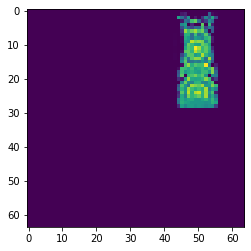

In [ ]:
plt.imshow(fashion_batch[0].cpu().detach().numpy().squeeze())

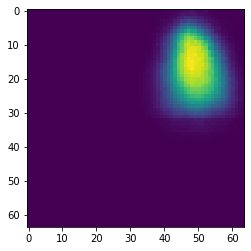

In [ ]:
plt.imshow(rec_img[0].cpu().detach().numpy().squeeze())